# Isolation Forest

# Origianl Data

In [3]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from scipy.ndimage import median_filter

# Load data
train_data = np.load("/home/haoqian/anomaly/Anomaly-TransformerX/dataset/SMD/SMD_train.npy")
test_data = np.load("/home/haoqian/anomaly/Anomaly-TransformerX/dataset/SMD/SMD_test.npy")
test_labels = np.load("/home/haoqian/anomaly/ml/fusion/SMD_test_label.npy")

# Preprocessing
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Feature engineering
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_data_scaled)
test_pca = pca.transform(test_data_scaled)

train_combined = np.hstack([train_data_scaled, train_pca])
test_combined = np.hstack([test_data_scaled, test_pca])

# Model with tuned parameters
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples=0.8,
    contamination=0.05,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(train_combined)

# Predict and post-process
test_scores = iso_forest.decision_function(test_combined)  # Get anomaly scores
test_predictions = np.where(test_scores < np.percentile(test_scores, 100 * 0.05), 1, 0)  # Top 5% as anomalies
test_predictions = median_filter(test_predictions, size=5)  # Smooth predictions
test_scores=-test_scores
# Evaluation
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)
auc_roc = roc_auc_score(test_labels, test_predictions)
ap_score = average_precision_score(test_labels, test_predictions)

print("=== Isolation Forest Model Performance ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC ROC Score: {auc_roc:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


=== Isolation Forest Model Performance ===
Precision: 0.2479
Recall: 0.2482
F1 Score: 0.2480
AUC ROC Score: 0.6078
Average Precision Score: 0.0928
Accuracy: 0.9375

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    678976
         1.0       0.25      0.25      0.25     29444

    accuracy                           0.94    708420
   macro avg       0.61      0.61      0.61    708420
weighted avg       0.94      0.94      0.94    708420



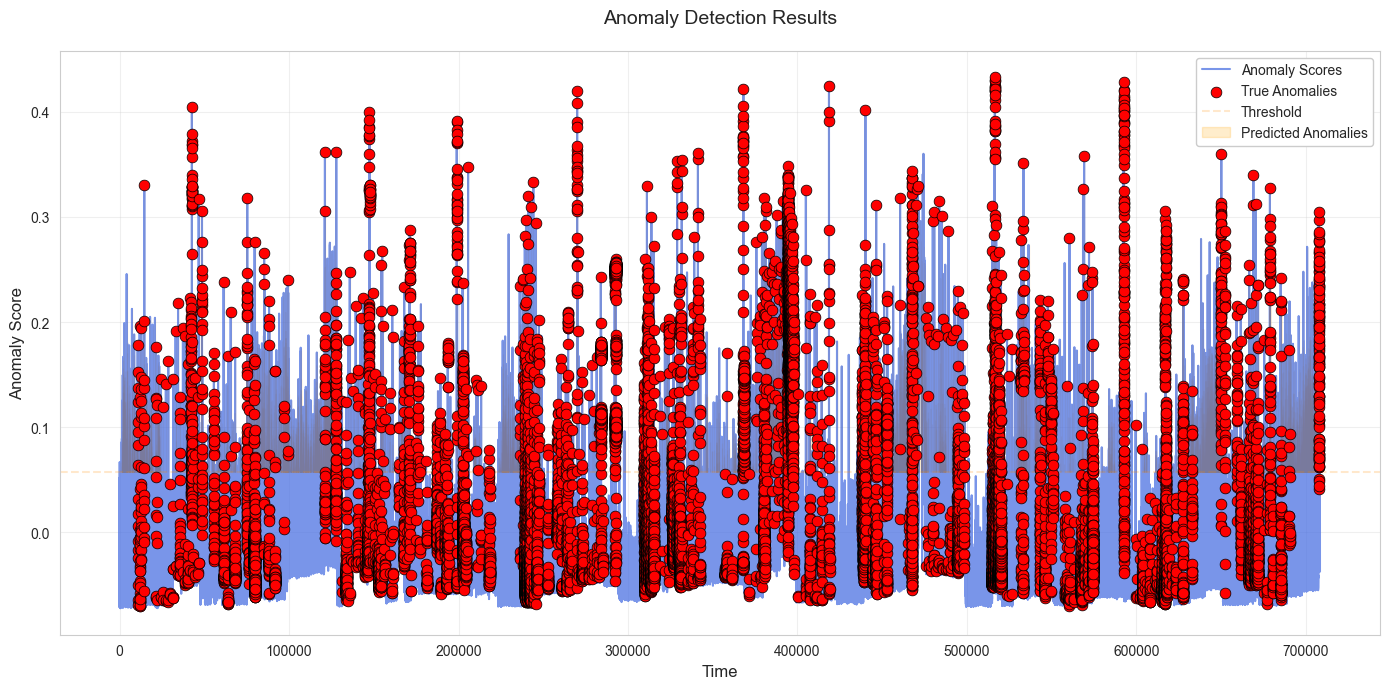

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Plot anomaly scores
plt.plot(test_scores, label='Anomaly Scores', color='royalblue', alpha=0.7, linewidth=1.5)

# Highlight true anomalies
anomaly_points = np.where(test_labels == 1)[0]
plt.scatter(anomaly_points, 
            test_scores[test_labels == 1], 
            color='red', 
            label='True Anomalies', 
            s=60,
            edgecolor='black',
            linewidth=0.5,
            zorder=3)

# Add threshold line if you have one
threshold = np.percentile(test_scores, 95)  
plt.axhline(y=threshold, color='darkorange', linestyle='--', 
            linewidth=1.5, alpha=0.2, label='Threshold')


plt.fill_between(range(len(test_scores)), 
                 test_scores, 
                 threshold, 
                 where=(test_scores > threshold),
                 color='orange', 
                 alpha=0.2, 
                 label='Predicted Anomalies')

# Add labels and title
plt.title('Anomaly Detection Results', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)

# Improve legend and grid
plt.legend(loc='upper right', framealpha=1)
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Feature Fusion

In [1]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from scipy.ndimage import median_filter
import joblib  # Import joblib for saving the model

# Load data
train_data = np.load("/home/haoqian/anomaly/ml/fusion/fusion_train.npy")
test_data = np.load("/home/haoqian/anomaly/ml/fusion/fusion_test.npy")
test_labels = np.load("/home/haoqian/anomaly/ml/fusion/SMD_test_label.npy")

# Preprocessing
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Feature engineering
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_data_scaled)
test_pca = pca.transform(test_data_scaled)

train_combined = np.hstack([train_data_scaled, train_pca])
test_combined = np.hstack([test_data_scaled, test_pca])

# Model with tuned parameters
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples=0.8,
    contamination=0.05,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(train_combined)

# Save the model parameters
model_path = '/home/haoqian/anomaly/ensamble-learning/models/isolation_forest_model.pkl'
joblib.dump(iso_forest, model_path)

# Predict and post-process
test_scores = iso_forest.decision_function(test_combined)  # Get anomaly scores
test_predictions = np.where(test_scores < np.percentile(test_scores, 100 * 0.05), 1, 0)  # Top 5% as anomalies
test_predictions = median_filter(test_predictions, size=5)  # Smooth predictions
test_scores = -test_scores

# Evaluation
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)
auc_roc = roc_auc_score(test_labels, test_predictions)
ap_score = average_precision_score(test_labels, test_predictions)

print("=== Isolation Forest Model Performance ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC ROC Score: {auc_roc:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))

=== Isolation Forest Model Performance ===
Precision: 0.2613
Recall: 0.2794
F1 Score: 0.2701
AUC ROC Score: 0.6226
Average Precision Score: 0.1030
Accuracy: 0.9372

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    678976
         1.0       0.26      0.28      0.27     29444

    accuracy                           0.94    708420
   macro avg       0.61      0.62      0.62    708420
weighted avg       0.94      0.94      0.94    708420



In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from scipy.ndimage import median_filter
import joblib  # Import joblib for loading the model

# Load the model
model_path = '/home/haoqian/anomaly/ensamble-learning/models/isolation_forest_model.pkl'
iso_forest = joblib.load(model_path)

# Load test data
test_data = np.load("/home/haoqian/anomaly/ml/fusion/fusion_test.npy")
test_labels = np.load("/home/haoqian/anomaly/ml/fusion/SMD_test_label.npy")

# Preprocessing
scaler = StandardScaler()
# Fit the scaler only on the training data used to train the model
# Here, we assume you have saved the scaler during training; otherwise, you should load it as well.
train_data = np.load("/home/haoqian/anomaly/ml/fusion/fusion_train.npy")
scaler.fit(train_data)  # Fit on training data

test_data_scaled = scaler.transform(test_data)

# Feature engineering
pca = PCA(n_components=0.95)
# Assume PCA was fitted during training; otherwise, load the fitted PCA model too.
train_data_scaled = scaler.transform(train_data)
pca.fit(train_data_scaled)  # Fit on training data

test_pca = pca.transform(test_data_scaled)

# Combine the scaled and PCA features
test_combined = np.hstack([test_data_scaled, test_pca])

# Predict and post-process
test_scores = iso_forest.decision_function(test_combined)  # Get anomaly scores
test_predictions = np.where(test_scores < np.percentile(test_scores, 100 * 0.05), 1, 0)  # Top 5% as anomalies
test_predictions = median_filter(test_predictions, size=5)  # Smooth predictions
test_scores = -test_scores

# Evaluation
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)
auc_roc = roc_auc_score(test_labels, test_predictions)
ap_score = average_precision_score(test_labels, test_predictions)

print("=== Isolation Forest Model Performance on Test Data ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC ROC Score: {auc_roc:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))

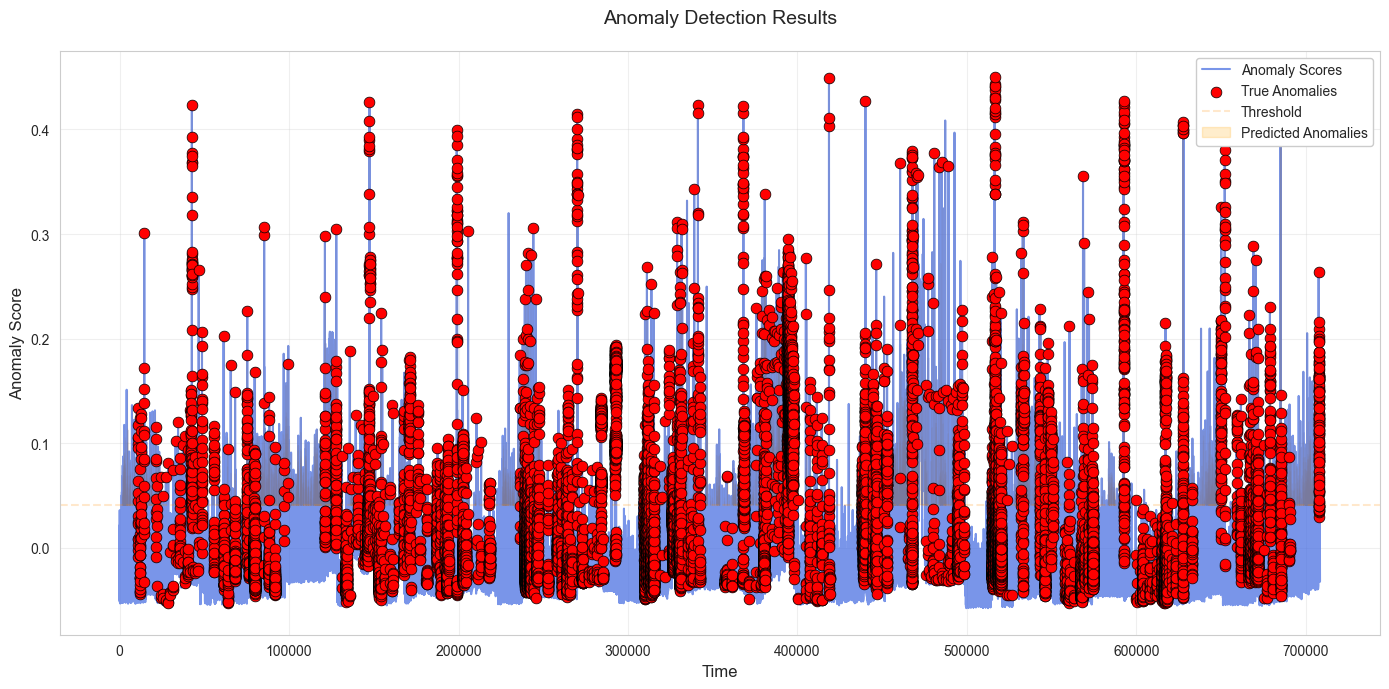

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Plot anomaly scores
plt.plot(test_scores, label='Anomaly Scores', color='royalblue', alpha=0.7, linewidth=1.5)

# Highlight true anomalies
anomaly_points = np.where(test_labels == 1)[0]
plt.scatter(anomaly_points, 
            test_scores[test_labels == 1], 
            color='red', 
            label='True Anomalies', 
            s=60,
            edgecolor='black',
            linewidth=0.5,
            zorder=3)

# Add threshold line if you have one
threshold = np.percentile(test_scores, 95)  
plt.axhline(y=threshold, color='darkorange', linestyle='--', 
            linewidth=1.5, alpha=0.2, label='Threshold')


plt.fill_between(range(len(test_scores)), 
                 test_scores, 
                 threshold, 
                 where=(test_scores > threshold),
                 color='orange', 
                 alpha=0.2, 
                 label='Predicted Anomalies')

# Add labels and title
plt.title('Anomaly Detection Results', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)

# Improve legend and grid
plt.legend(loc='upper right', framealpha=1)
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()